In [1]:
#
# COMMENTS TO DO
#

%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import time
import glob

from tensorflow.examples.tutorials.mnist import input_data

def plot(samples, w, h, fw, fh, iw=28, ih=28):
    fig = plt.figure(figsize=(fw, fh))
    gs = gridspec.GridSpec(w, h)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(iw, ih), cmap='Greys_r')

    return fig



def conv_batch_norm(inputs,
                    name="batch_norm",
                    is_training=True,
                    trainable=True,
                    epsilon=1e-5):
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    shp = inputs.get_shape()[-1].value

    with tf.variable_scope(name) as scope:
        gamma = tf.get_variable("gamma", [shp], initializer=tf.random_normal_initializer(1., 0.02), trainable=trainable)
        beta = tf.get_variable("beta", [shp], initializer=tf.constant_initializer(0.), trainable=trainable)

        mean, variance = tf.nn.moments(inputs, [0, 1, 2])
        mean.set_shape((shp,))
        variance.set_shape((shp,))
        ema_apply_op = ema.apply([mean, variance])

        def update():
            with tf.control_dependencies([ema_apply_op]):
                return tf.nn.batch_norm_with_global_normalization(
                    inputs, mean, variance, beta, gamma, epsilon,
                    scale_after_normalization=True
                )
        def do_not_update():
            return tf.nn.batch_norm_with_global_normalization(
                inputs, ema.average(mean), ema.average(variance), beta,
                gamma, epsilon,
                scale_after_normalization=True
            )

        normalized_x = tf.cond(
            is_training,
            update,
            do_not_update
        )
        return normalized_x

   

def encoder(images, is_training=True):
        
    with tf.variable_scope("encoder") as scope:
        
        #Workaround: Dimensions hard-coded! Fix it in the future :)
        #images_70x70x1 = tf.reshape(images, [-1, 70, 70, 1])
         
        images_70x70x1 = images
        
        h0 = layers.convolution2d(
            inputs=images_70x70x1,
            num_outputs=32,
            kernel_size=5,
            stride=1,
            normalizer_fn=conv_batch_norm,
            normalizer_params={"is_training": is_training},
            activation_fn=tf.nn.relu,
            scope='e_cnn_%d' % (0,)
        )
        
        print(h0)


        h0_max_pooled = tf.nn.max_pool(h0, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        print(h0_max_pooled)

        h1 = layers.convolution2d(
            inputs=h0_max_pooled,
            num_outputs=64,
            kernel_size=5,
            stride=1,
            normalizer_fn=conv_batch_norm,
            normalizer_params={"is_training": is_training},
            activation_fn=tf.nn.relu,
            scope='e_cnn_%d' % (1,)
        )
        
        print(h1)


        h1_max_pooled = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        print(h1_max_pooled)
        
        h2 = layers.convolution2d(
            inputs=h1_max_pooled,
            num_outputs=128,
            kernel_size=5,
            stride=1,
            normalizer_fn=conv_batch_norm,
            normalizer_params={"is_training": is_training},
            activation_fn=tf.nn.relu,
            scope='e_cnn_%d' % (2,)
        )
        
        print(h2)


        h2_max_pooled = tf.nn.max_pool(h2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        print(h2_max_pooled)

        h2_flat = tf.reshape(h2_max_pooled, [-1, 9*9*128])
        
        print(h2_flat)

        h2_flat =layers.fully_connected(
            inputs=h2_flat,
            num_outputs=1024,
            activation_fn=tf.nn.relu,
            normalizer_fn=layers.batch_norm,
            normalizer_params={"is_training": is_training, "updates_collections": None},
            scope='e_d_%d' % (0,)
        )
        
        print(h2_flat)

        z_mean =layers.fully_connected(
            inputs=h2_flat,
            num_outputs=128,
            activation_fn=None,
            normalizer_fn=None,
            normalizer_params={"is_training": is_training, "updates_collections": None},
            scope='e_d_%d' % (1,)
        )
        
        z_log_sigma_sq =layers.fully_connected(
            inputs=h2_flat,
            num_outputs=128,
            activation_fn=None,
            normalizer_fn=None,
            normalizer_params={"is_training": is_training, "updates_collections": None},
            scope='e_d_%d' % (2,)
        )
        
        return z_mean, z_log_sigma_sq 
    
    

def decoder(z, is_training=True):
        
    with tf.variable_scope("decoder") as scope:
        
        h0 =layers.fully_connected(
            inputs=z,
            num_outputs=1024,
            activation_fn=None,
            normalizer_fn=None,
            normalizer_params={"is_training": is_training, "updates_collections": None},
            scope='d_d_%d' % (0,)
        )
        
        print(h0)
        
        h1 =layers.fully_connected(
            inputs=h0,
            num_outputs=10368,
            activation_fn=None,
            normalizer_fn=None,
            normalizer_params={"is_training": is_training, "updates_collections": None},
            scope='d_d_%d' % (1,)
        )
        
        print(h1)
        
        h1_reshape = tf.reshape(h1, [-1, 9, 9, 128])
        
        print(h1_reshape)
        
        wdd2 = tf.get_variable('wd2', shape=(5, 5, 128, 128), initializer=tf.contrib.layers.xavier_initializer())
        bdd2 = tf.get_variable('bd2', shape=(128,), initializer=tf.constant_initializer(0))
        
        h2 = tf.nn.conv2d_transpose(h1_reshape, wdd2, output_shape=(100, 18, 18, 128), strides=(1, 2, 2, 1), padding='SAME')
    
        h2_out = tf.nn.relu(h2 + bdd2)
        
        print(h2_out)
        
        wdd3 = tf.get_variable('wd3', shape=(5, 5, 64, 128), initializer=tf.contrib.layers.xavier_initializer())
        bdd3 = tf.get_variable('bd3', shape=(64,), initializer=tf.constant_initializer(0))
        
        h3 = tf.nn.conv2d_transpose(h2_out, wdd3, output_shape=(100, 35, 35, 64), strides=(1, 2, 2, 1), padding='SAME')
    
        h3_out = tf.nn.relu(h3 + bdd3)
                
        print(h3_out)
        
        wdd4 = tf.get_variable('wd4', shape=(5, 5, 1, 64), initializer=tf.contrib.layers.xavier_initializer())
        bdd4 = tf.get_variable('bd4', shape=(1,), initializer=tf.constant_initializer(0))
        
        h4 = tf.nn.conv2d_transpose(h3_out, wdd4, output_shape=(100, 70, 70, 1), strides=(1, 2, 2, 1), padding='SAME')
    
        h4_out = tf.nn.relu(h4 + bdd4)
                
        print(h4_out)
        
        return h4_out

images = tf.placeholder(tf.float32, shape=(None, 70, 70, 1))
images_target = tf.placeholder(tf.float32, shape=(None, 70, 70, 1))

is_training_placeholder = tf.placeholder(tf.bool)
learning_rate_placeholder = tf.placeholder(tf.float32)

z_mean, z_log_sigma_sq = encoder(images, is_training_placeholder)

eps = tf.random_normal(shape=tf.shape(z_mean), mean=0.0, stddev=1.0, dtype=tf.float32)

z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
        
x_reconstr_mean = decoder(z, is_training_placeholder)

reconstr_loss = -tf.reduce_sum(images_target * tf.log(1e-10 + x_reconstr_mean) + (1-images_target) * tf.log(1e-10 + 1 - x_reconstr_mean), 1)

latent_loss = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq), 1)

cost = tf.reduce_mean(reconstr_loss + latent_loss)

optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate_placeholder).minimize(cost)

Tensor("encoder/e_cnn_0/Relu:0", shape=(?, 70, 70, 32), dtype=float32)
Tensor("encoder/MaxPool:0", shape=(?, 35, 35, 32), dtype=float32)
Tensor("encoder/e_cnn_1/Relu:0", shape=(?, 35, 35, 64), dtype=float32)
Tensor("encoder/MaxPool_1:0", shape=(?, 18, 18, 64), dtype=float32)
Tensor("encoder/e_cnn_2/Relu:0", shape=(?, 18, 18, 128), dtype=float32)
Tensor("encoder/MaxPool_2:0", shape=(?, 9, 9, 128), dtype=float32)
Tensor("encoder/Reshape:0", shape=(?, 10368), dtype=float32)
Tensor("encoder/e_d_0/Relu:0", shape=(?, 1024), dtype=float32)
Tensor("decoder/d_d_0/BiasAdd:0", shape=(?, 1024), dtype=float32)
Tensor("decoder/d_d_1/BiasAdd:0", shape=(?, 10368), dtype=float32)
Tensor("decoder/Reshape:0", shape=(?, 9, 9, 128), dtype=float32)
Tensor("decoder/Relu:0", shape=(100, 18, 18, 128), dtype=float32)
Tensor("decoder/Relu_1:0", shape=(100, 35, 35, 64), dtype=float32)
Tensor("decoder/Relu_2:0", shape=(100, 70, 70, 1), dtype=float32)


In [2]:

DATA_PATH = "DATASET/"

file_list = glob.glob(DATA_PATH + "*")

print("\n".join(file_list))



# lista de imágenes de 70x70 escritas a mano para el entrenamiento
X_train_img = np.load(DATA_PATH + "X_train_img.npy")
# lista de etiquetas en formato one-hot vector de las imágenes anteriores
Y_train_one_hot = np.load(DATA_PATH + "Y_train_one_hot.npy")

#  lo mismo para el caso del test
X_test_img  = np.load(DATA_PATH + "X_test_img.npy")
Y_test_one_hot = np.load(DATA_PATH + "Y_test_one_hot.npy")


#  imágenes de los caracteres escritos a ordenador de tamaño 70x70
X_original = np.load(DATA_PATH + "X_original.npy")
# las mismas imágenes pero extraídas con un bounding box de la misma forma que las imágenes de train/test
BB_original  = np.load(DATA_PATH + "BB_original.npy")
#  las etiquetas correspondientes a cada imagen
Y_original = np.load(DATA_PATH + "Y_original.npy")

print(X_train_img.shape)
print(X_test_img.shape)
print(BB_original.shape)
print(Y_train_one_hot.shape)

print(Y_original.shape)

"""
fig=plot(X_train_img[:100], 10, 10, 10, 10, 70, 70)
plt.show()

print(np.argmax(Y_train_one_hot, axis=1))

fig=plot(X_test_img[:100], 10, 10, 10, 10, 70, 70)
plt.show()


fig=plot(X_original[:100], 10, 10, 10, 10, 70, 70)
plt.show()


fig=plot(BB_original[:100], 10, 10, 10, 10, 70, 70)
plt.show()

label = 56

indexes = np.where(Y_train_one_hot[:,label] == 1)
fig=plot(X_train_img[indexes[0][:100]], 10, 10, 10, 10, 70, 70)
plt.show()

indexes = np.where(Y_original == label)
fig=plot(X_original[indexes[0][:100]], 10, 10, 10, 10, 70, 70)
plt.show()
"""


X_total = X_original.shape[0]
X_dim_1 = X_original.shape[1]
X_dim_2 = X_original.shape[2]


print(X_original.shape)


X_original_matching = np.zeros((X_train_img.shape[0], 70, 70))

for ind in range(X_train_img.shape[0]):
    
    corresponding_label = Y_train_one_hot[ind]
    n_label = np.argmax(corresponding_label, axis=0)
    
    indexes = np.where(Y_original == n_label)
    X_original_matching[ind] = X_original[indexes[0]].copy()
    #print(indexes[0])
    #print(corresponding_label)
    #print(np.argmax(corresponding_label, axis=0))



X_train_img/=255.0
X_original_matching/=255.0
#fig=plot(X_train_img[:100], 10, 10, 10, 10, 70, 70)
#plt.show()
#fig=plot(X_original_matching[:100], 10, 10, 10, 10, 70, 70)
#plt.show()

#fig=plot(X_train_img[78:80], 1, 2, 10, 10, 70, 70)
#plt.show()

#print(X_train_img[78:80])

DATASET/Y_original.npy
DATASET/X_test_img.npy
DATASET/BB_original.npy
DATASET/X_original.npy
DATASET/X_train_img.npy
DATASET/Y_test_one_hot.npy
DATASET/Y_train_one_hot.npy
(5820, 70, 70)
(5820, 70, 70)
(97, 70, 70)
(5820, 97)
(97,)
(97, 70, 70)


N. Batches: 58
[50  7 43  1 14 23  5 10  8 44 55 39 51 46  9 31 16 22 21 20 33 19 25  3 11
 32 56 37 35 28  0 53 48 12 47 36  2 27 49 13  4 40 15 38 54 24 42 17 34 18
 45 26 52 41 30 57 29  6]
Epoch 0, Mean Loss 534.22


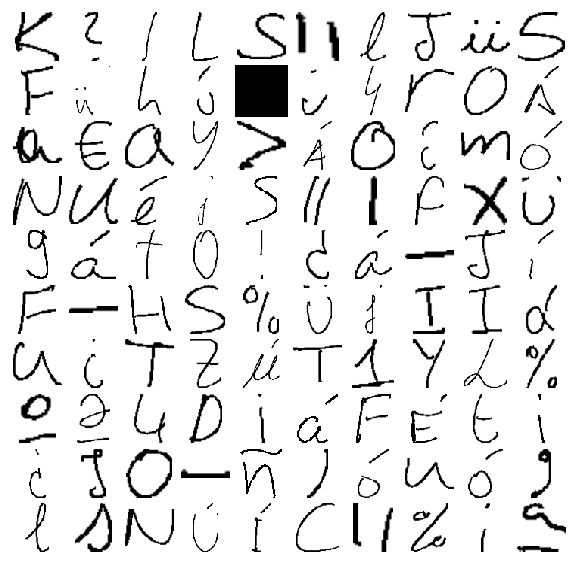

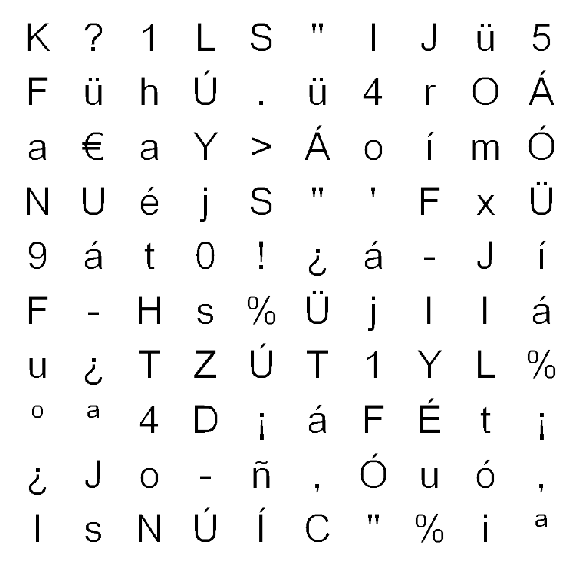

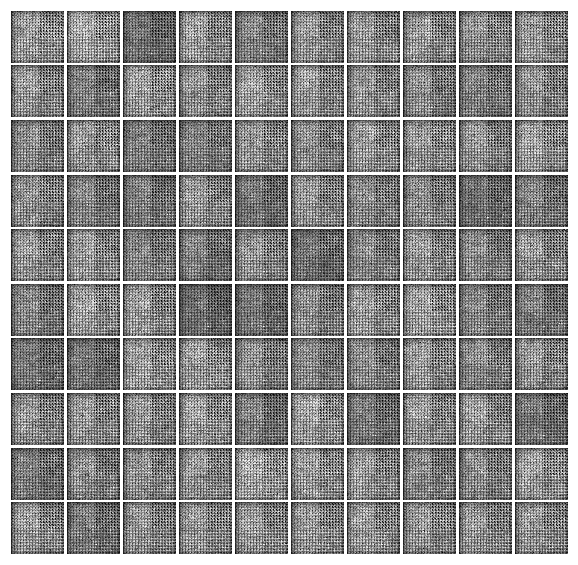

[53 11 14 38 10  8 47 44 49 17 12 19 26  9 56  0 46 32 36 43 28 29 18 16  7
  4 55 31 51 30 13 50 41 48 39 45  1 35  5 42 52 25  2 23 40 27  6 21 34 15
  3 57 37 24 54 20 22 33]
Epoch 1, Mean Loss 179.32


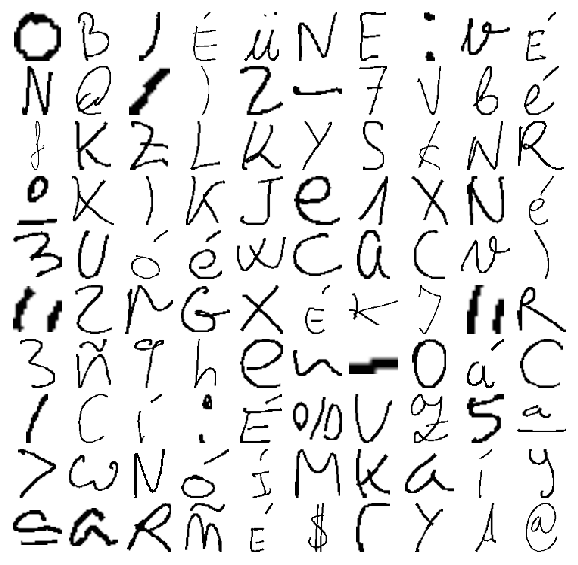

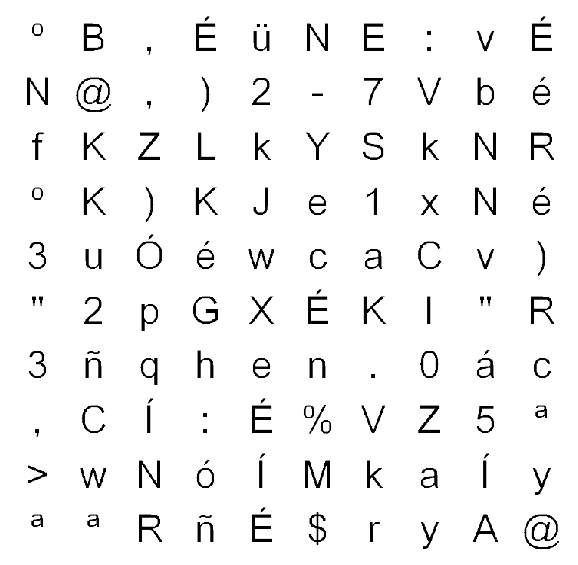

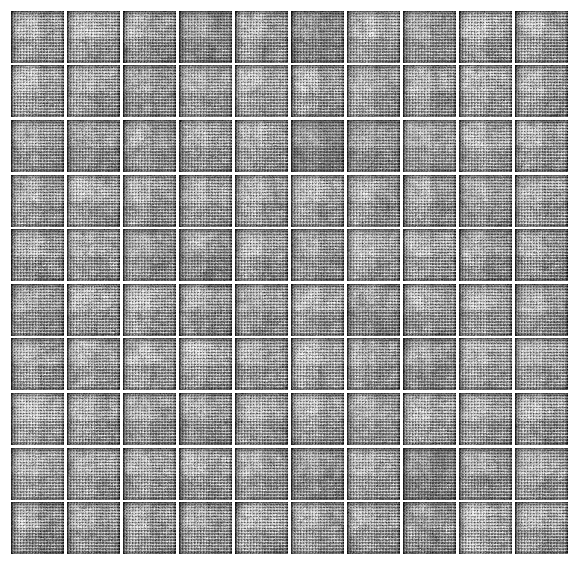

[16 22 25 43 48 53 10 42  1 38 24 51 23  2 19 44  3 46 28 47  8 36 49 55 41
 14 39 35 54 20 45 37 56 50 31 33  9 12  4 30 13  0 15  7  5 40  6 21 26 32
 34 11 17 52 29 27 57 18]
Epoch 2, Mean Loss 132.11


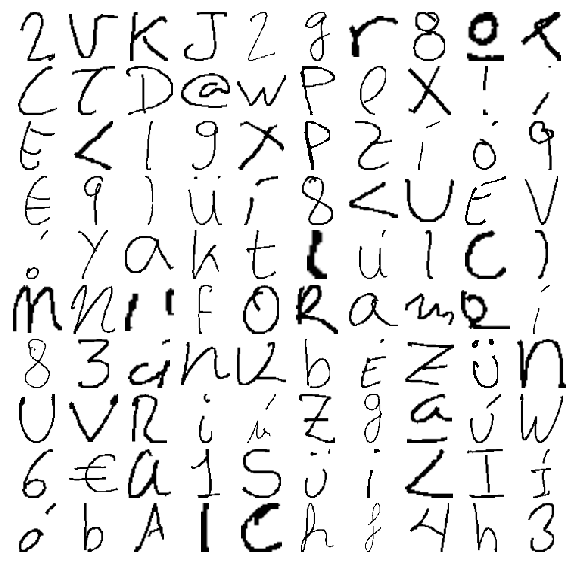

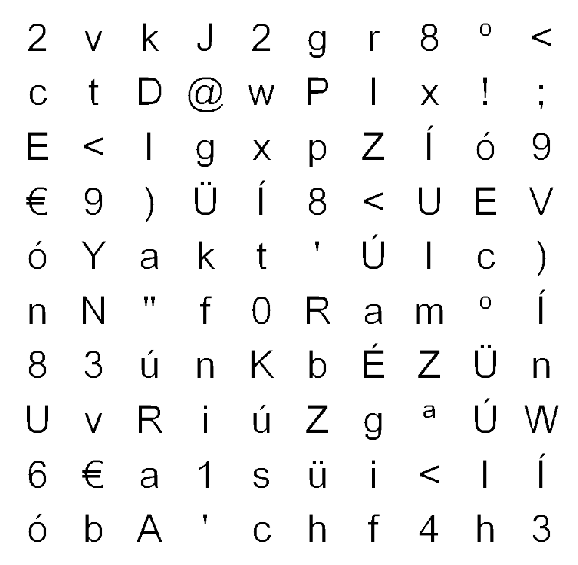

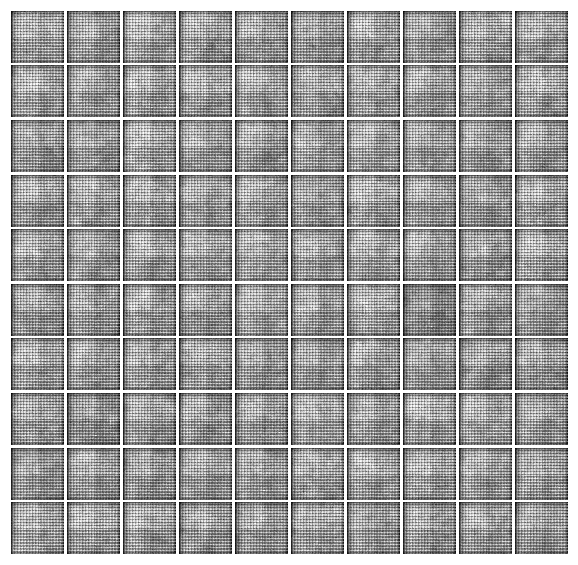

[18 27 56 48 36 15 14 26  1  5 19 37 38 21 52 33  3 30 34 51 44 47 29 17 45
 12 42 46 54 16 28  9 49  6 39 13 35 10 57 20 23 31 32 50 43 53 55 22 24 11
  2 41  0  8  4 40 25  7]
Epoch 3, Mean Loss nan


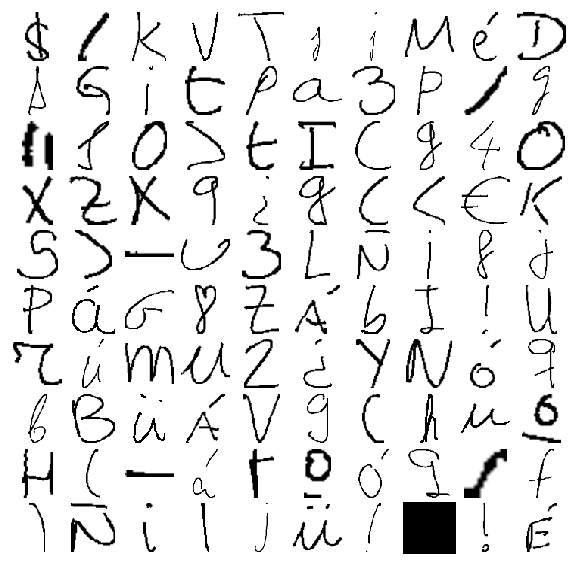

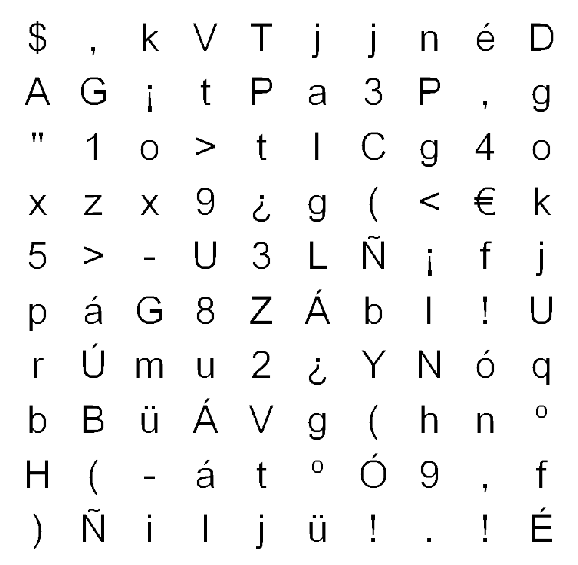

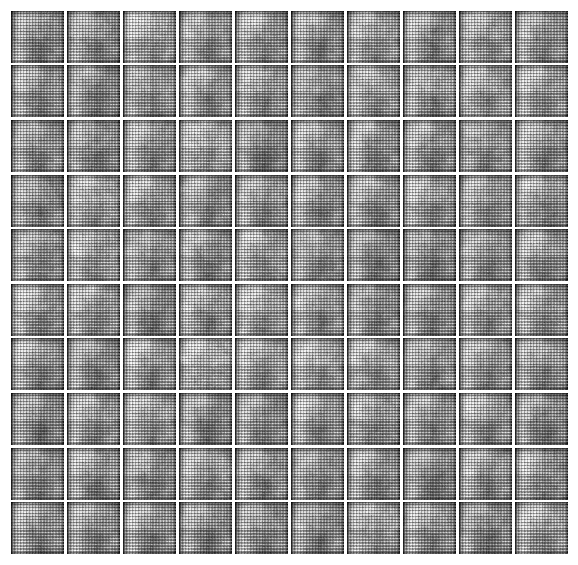

[33 25 29  3 44 14  6 40 19 24 38 52 21 43 54 39 47 48 32 22 49 16 55  8  0
 27 15 42  1  9 36 34 11 46 56 10  5 57 23 20 53 18  4 50 31 41 45 28 13 51
 35 17 37  2 12 30 26  7]


KeyboardInterrupt: 

In [8]:

init = tf.global_variables_initializer()

epochs = 10000
batch_size = 100

n_batches = X_train_img.shape[0]//batch_size

learning_rate=0.0001


print("N. Batches: {}".format(n_batches))

# Launch the graph
with tf.Session() as sess:
    
    sess.run(init)
    
    
    for epoch in range(epochs):
        
        perm = np.random.permutation(n_batches)
        
        print(perm)
        
        mean_loss = 0

        for n_batch in perm:

            X_batch, Y_batch = X_train_img[n_batch*batch_size:(n_batch+1)*batch_size],  Y_train_one_hot[n_batch*batch_size:(n_batch+1)*batch_size]
            X_batch_resh = X_batch.reshape((batch_size, 70, 70, 1))
            
            X_batch_target = X_original_matching[n_batch*batch_size:(n_batch+1)*batch_size]
            X_batch_target_resh = X_batch_target.reshape((batch_size, 70, 70, 1))
            
            out_recon, out_recon_loss, out_latent_loss, out_cost, _ = sess.run([
                x_reconstr_mean, reconstr_loss, latent_loss, cost, optimizer], 
                           feed_dict={
                               images: X_batch_target_resh, 
                               images_target: X_batch_target_resh, 
                               is_training_placeholder: True,
                               learning_rate_placeholder: learning_rate})


            mean_loss += out_cost
            print(" Loss {:.2f} | Recon. Loss {:.2f} | Latent Loss {:.2f}".format(
                out_cost, out_recon_loss, out_latent_loss))
            
        print("Epoch {}, Mean Loss {:.2f}".format(epoch, mean_loss/n_batches))
        
        fig=plot(X_batch_resh, 10, 10, 10, 10, 70, 70)
        plt.show()
        fig=plot(X_batch_target_resh, 10, 10, 10, 10, 70, 70)
        plt.show()
        fig=plot(out_recon, 10, 10, 10, 10, 70, 70)
        plt.show()
